# Implementing facial key point detection

# Solving Use Case Pipeline

1. **Import Relevant Packages:**
   - Ensure necessary libraries are imported for data manipulation, model building, and training.

2. **Import Data:**
   - Load the dataset required for the use case, ensuring it includes both input images and corresponding key point locations.

3. **Define Dataset Preparation Class:**
   - Create a class responsible for preparing the dataset.
   - Implement appropriate pre-processing for input images to facilitate transfer learning.
   - Process key point locations to obtain their relative positions with respect to the pre-processed images.

4. **Define Model, Loss Function, and Optimizer:**
   - Specify the architecture of the model suitable for the use case.
   - Choose the mean absolute error as the loss function, given the output is a continuous value between 0 and 1.
   - Select an optimizer for model training.

5. **Train the Model:**
   - Train the defined model over increasing epochs.
   - Monitor the training process for convergence and performance improvement.



In [1]:
# 1. Import the relevant packages and the dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchsummary import summary
import numpy as np
import pandas as pd
import cv2 ,glob, os
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.model_selection import train_test_split

# Check and set the device to CUDA if available, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Print the selected device
print(f"Using device: {device}")

Using device: cuda


In [2]:
# 2. Download and import the relevant data

!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')


Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038
Receiving objects: 100% (6049/6049), 329.53 MiB | 15.47 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [ ]:
data


The dataset has the following structure:

- **Column 1 (Name of the Image):**
  - Represents the name or identifier of the image.

- **Even Columns (x-axis values for 68 Key Points):**
  - Contains the x-axis coordinates corresponding to each of the 68 key points on the face.

- **Odd Columns (y-axis values for 68 Key Points):**
  - Except for the first column, these contain the y-axis coordinates corresponding to each of the 68 key points on the face.



In [3]:
# 3.Define the FacesData class that provides input and output data points for the data loader
class FacesData(Dataset):
    def __init__(self, df, root_dir='P1_Facial_Keypoints/data/training/'):
        super(FacesData, self).__init__()
        self.df = df
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        img_path = f"{self.root_dir}{self.df.iloc[ix, 0]}"
        img = cv2.imread(img_path) / 255.0
        kp = np.array(self.df.iloc[ix, 1:])
        kp_x = (kp[0::2] / img.shape[1]).tolist()
        kp_y = (kp[1::2] / img.shape[0]).tolist()
        kp2 = torch.tensor(kp_x + kp_y).float()

        img = self.preprocess_input(img)
        return img, kp2

    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img.to(device)

    def load_img(self, ix):
        img_path = f"{self.root_dir}{self.df.iloc[ix, 0]}"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        img = cv2.resize(img, (224, 224))
        return img

In [4]:
# 4. create a training and test data split and establish training and test datasets and data loaders
# Split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=101)

# Create train and test datasets
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

# Create train and test data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# 5. Let's now define the model that we will leverage to identify key points in an image
def get_keypoints_model():
    # Load pre-trained VGG16 model from torchvision
    model = models.vgg16(weights='IMAGENET1K_V1')

    # Freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # Modify the model architecture
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten()
    )

    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()
    )

    # Define the loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Move the model to the selected device (cuda or cpu)
    return model.to(device), criterion, optimizer


# 7. Define functions to train on a batch of data points and also to validate on the test dataset
def train_batch(img, kps, model, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  loss.backward()
  optimizer.step()
  return loss

#  function that returns the loss on test data and the predicted key points
def validate_batch(img, kps, model, criterion):
  model.eval()
  with torch.inference_mode():
    _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  return _kps, loss


In [6]:
# Set up the model, criterion, and optimizer
model, criterion, optimizer = get_keypoints_model()

# Training and testing loop
train_losses, test_losses = [], []
n_epochs = 50

for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} : 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 59.8MB/s]


 epoch 1 : 50
 epoch 2 : 50
 epoch 3 : 50
 epoch 4 : 50
 epoch 5 : 50
 epoch 6 : 50
 epoch 7 : 50
 epoch 8 : 50
 epoch 9 : 50
 epoch 10 : 50
 epoch 11 : 50
 epoch 12 : 50
 epoch 13 : 50
 epoch 14 : 50
 epoch 15 : 50
 epoch 16 : 50
 epoch 17 : 50
 epoch 18 : 50
 epoch 19 : 50
 epoch 20 : 50
 epoch 21 : 50
 epoch 22 : 50
 epoch 23 : 50
 epoch 24 : 50
 epoch 25 : 50
 epoch 26 : 50
 epoch 27 : 50
 epoch 28 : 50
 epoch 29 : 50
 epoch 30 : 50
 epoch 31 : 50
 epoch 32 : 50
 epoch 33 : 50
 epoch 34 : 50
 epoch 35 : 50
 epoch 36 : 50
 epoch 37 : 50
 epoch 38 : 50
 epoch 39 : 50
 epoch 40 : 50
 epoch 41 : 50
 epoch 42 : 50
 epoch 43 : 50
 epoch 44 : 50
 epoch 45 : 50
 epoch 46 : 50
 epoch 47 : 50
 epoch 48 : 50
 epoch 49 : 50
 epoch 50 : 50


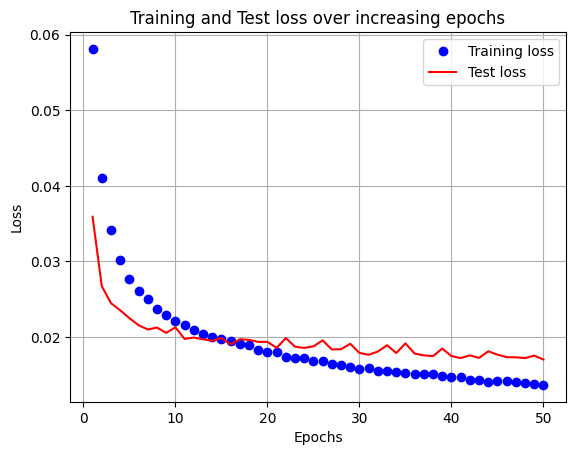

In [9]:
# 9. Plot the training and test loss over increasing epochs:
epochs = np.arange(50)+1

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, test_losses, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

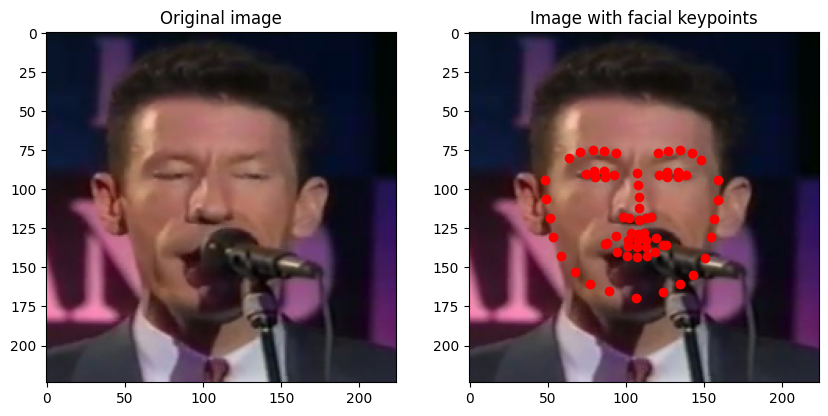

In [12]:
# 10. Test our model on a random test image's index
ix = 2
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()